In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


['cats', 'dogs']


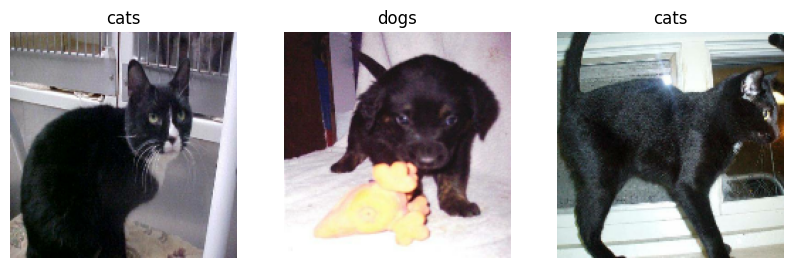

In [4]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

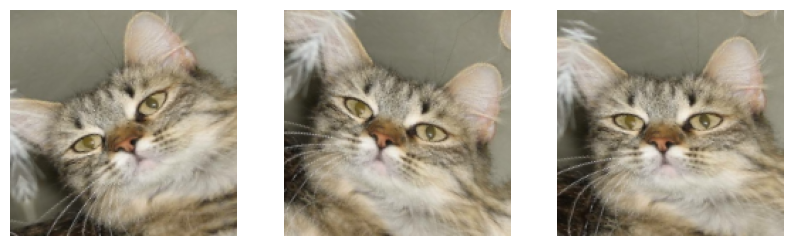

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [33]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [14]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 2,225,153 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [15]:
len(model.trainable_variables)

158

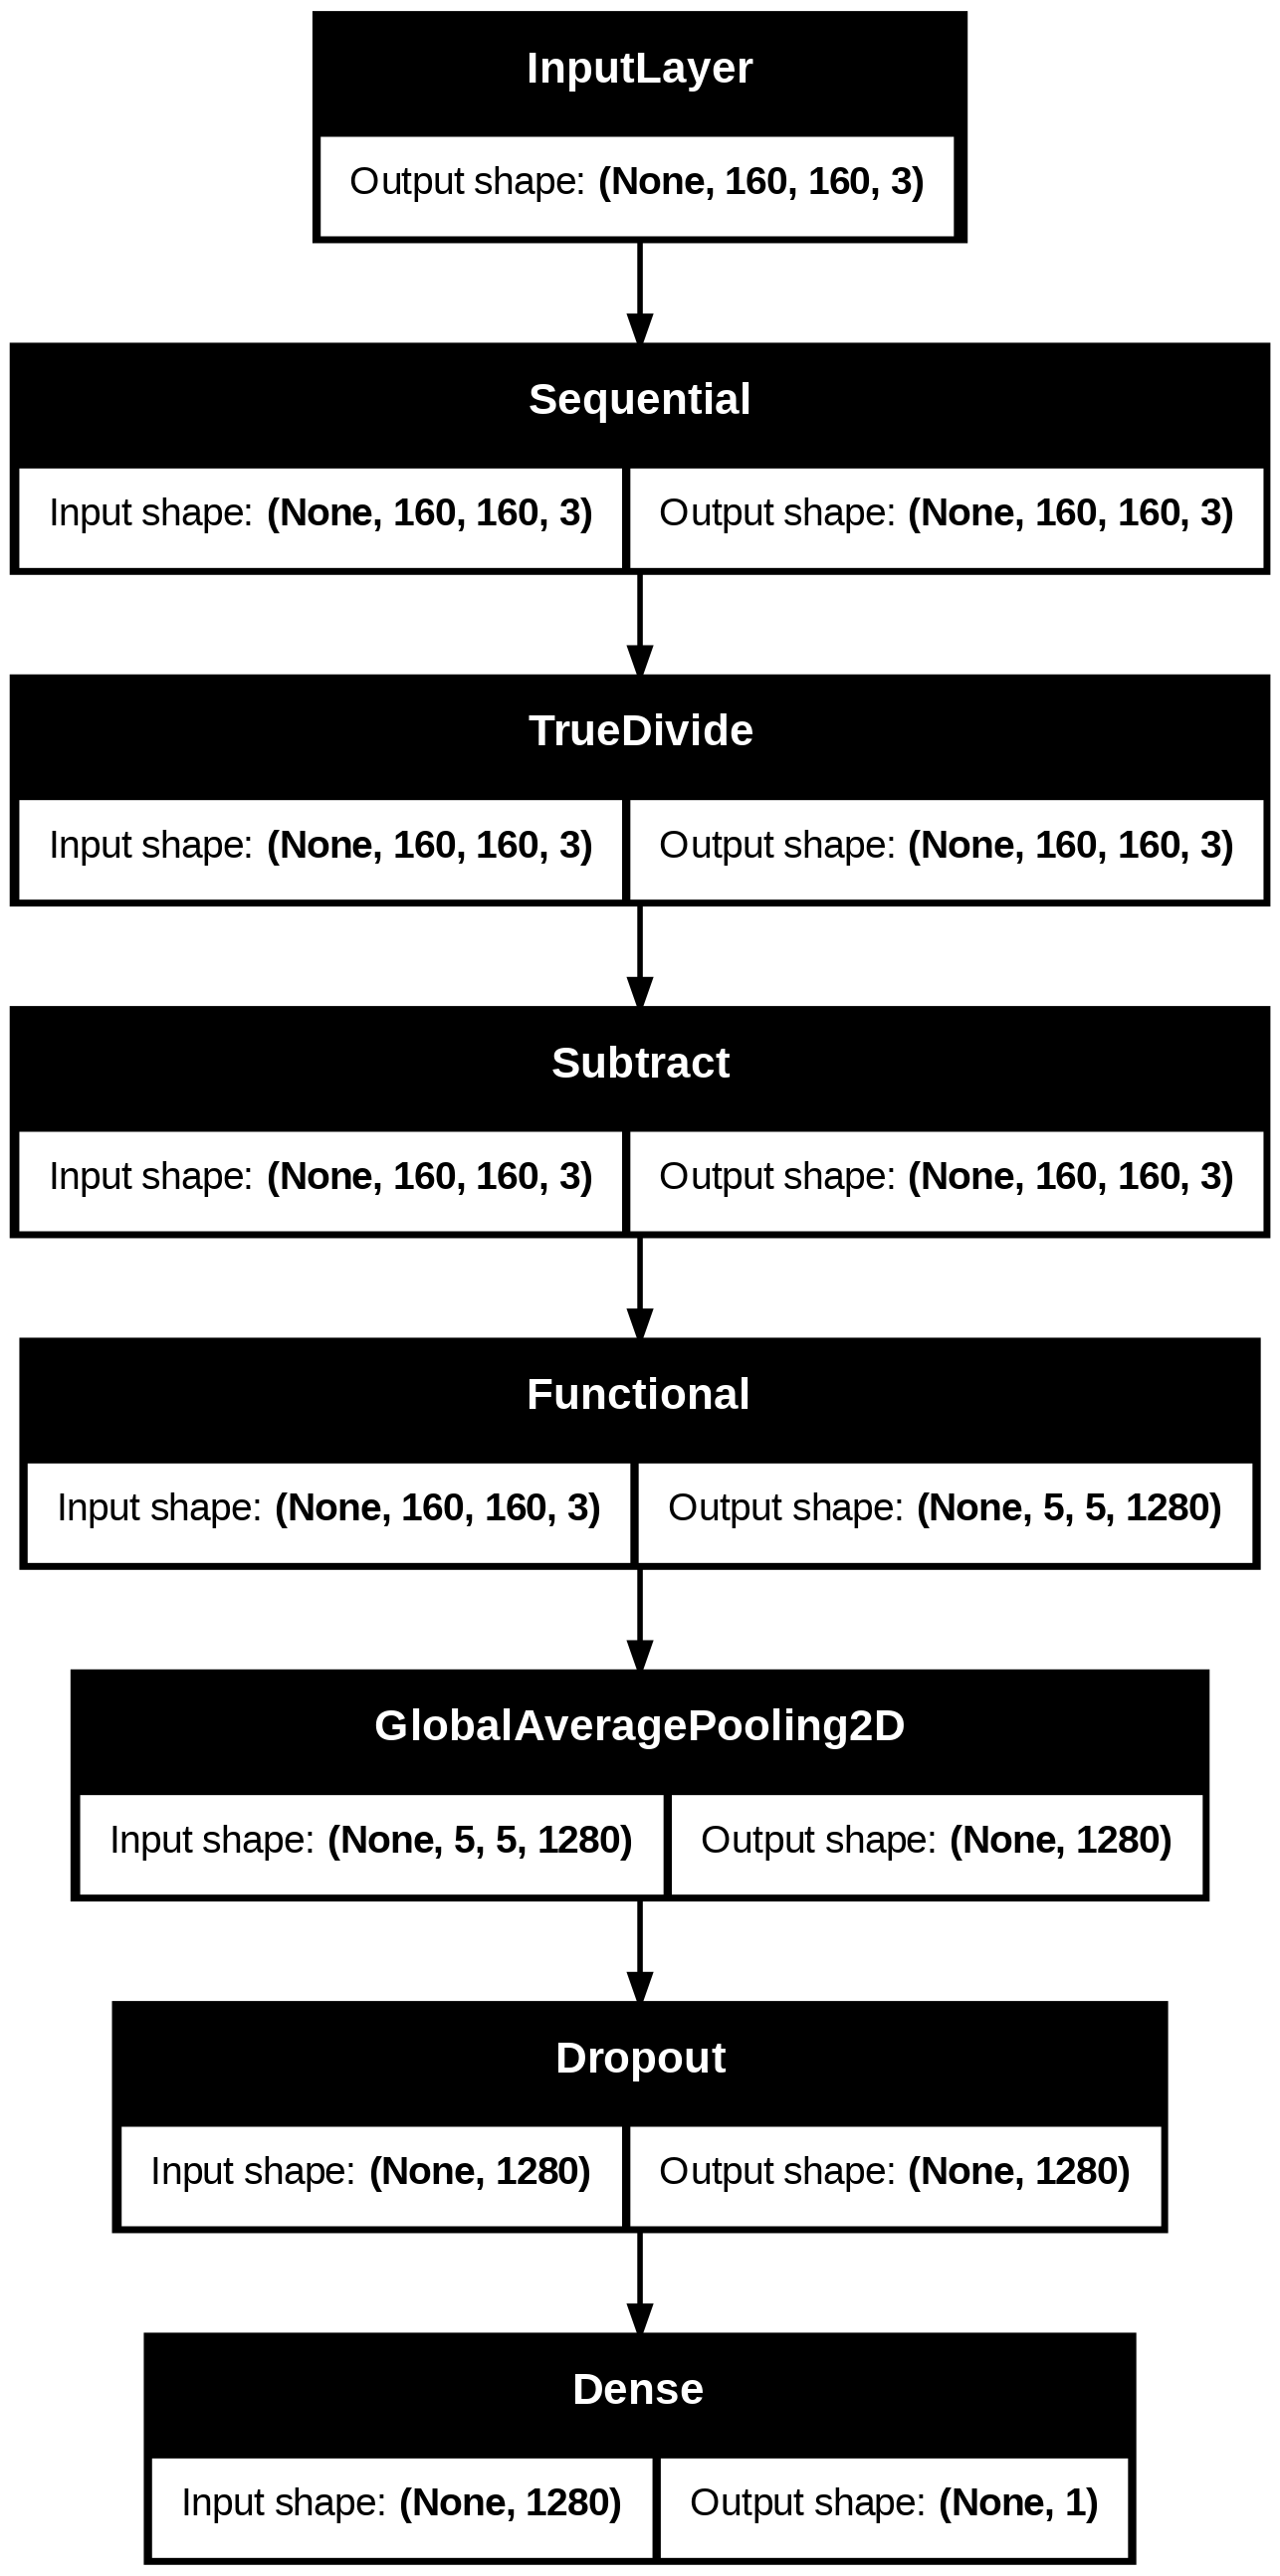

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [18]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5471 - loss: 0.7170
initial loss: 0.72
initial accuracy: 0.55


In [19]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.8078 - loss: 0.3762 - val_accuracy: 0.9715 - val_loss: 0.0780
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - accuracy: 0.9365 - loss: 0.1507 - val_accuracy: 0.9604 - val_loss: 0.1244
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.9499 - loss: 0.1192 - val_accuracy: 0.9653 - val_loss: 0.1216
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.9674 - loss: 0.0795 - val_accuracy: 0.9827 - val_loss: 0.0703
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.9733 - loss: 0.0685 - val_accuracy: 0.9752 - val_loss: 0.0944
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.9835 - loss: 0.0445 - val_accuracy: 0.9765 - val_loss: 0.0987
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.9839 - loss: 0.0532 - val_accuracy: 0.9790 - val_loss: 0.0819
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 175ms/step - accuracy: 0.9762 - loss: 0.0592 - val_accu

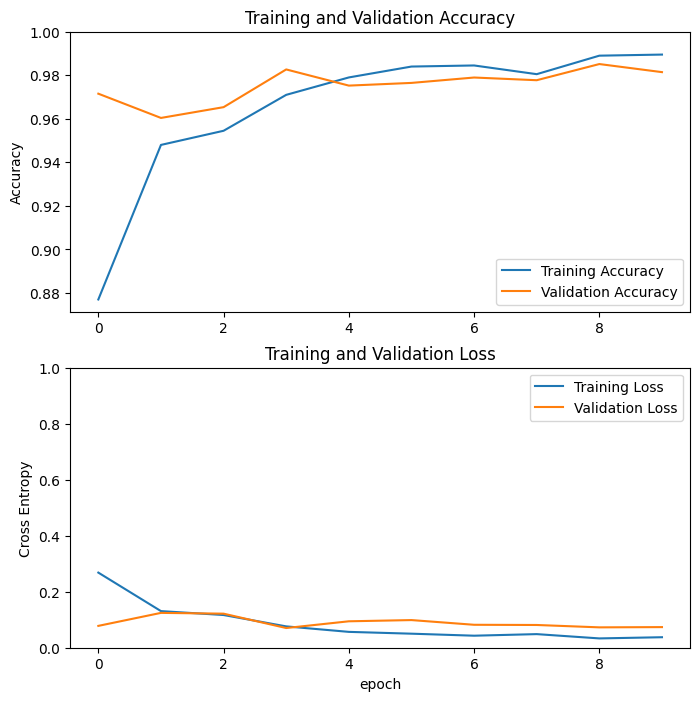

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9930 - loss: 0.0176
Test accuracy : 0.9895833134651184


Predictions:
 [0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1]
Labels:
 [0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1]


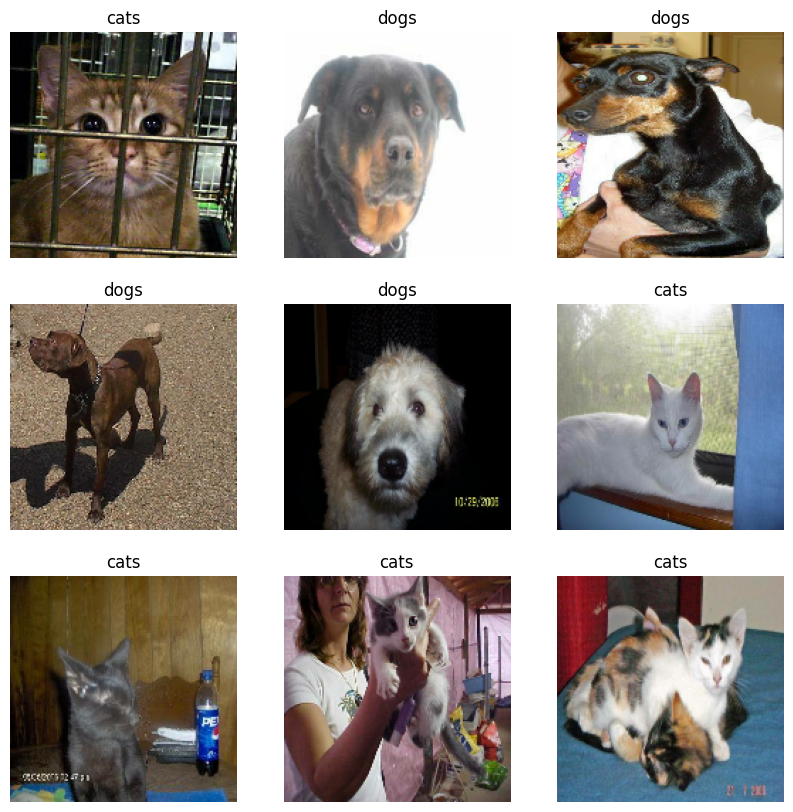

In [24]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")